In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch.nn.functional as F


from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch
import matplotlib.pyplot as plt
import time

In [28]:
# check torch
import torch

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name NVIDIA GeForce RTX 3060


In [29]:
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True):
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        
    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir, gt_dir):
        
        files = {'red': r_file, 
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}

        return files
                                       
    def __len__(self):
        
        return len(self.files)

    def open_as_array(self, idx, invert=False, include_nir=False):
        raw_rgb = np.stack([
            np.array(Image.open(self.files[idx]['red'])),
            np.array(Image.open(self.files[idx]['green'])),
            np.array(Image.open(self.files[idx]['blue'])),
        ], axis=2)

        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), axis=2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)

        if invert:
            raw_rgb = raw_rgb.transpose((2, 0, 1))

        # Normalize
        return raw_rgb / np.iinfo(raw_rgb.dtype).max




    def open_mask(self, idx, add_dims=False):
        
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)
        
        return x, y

In [30]:
# create torch dataset like defined in CloudDataset class
#E:\Cloudsarchive\95-cloud_training_only_additional_to38-cloud
base_path = Path('./38-Cloud_training')
data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt')
len(data)

8400

In [31]:
x, y = data[1000]
x.shape, y.shape

(torch.Size([3, 384, 384]), torch.Size([384, 384]))

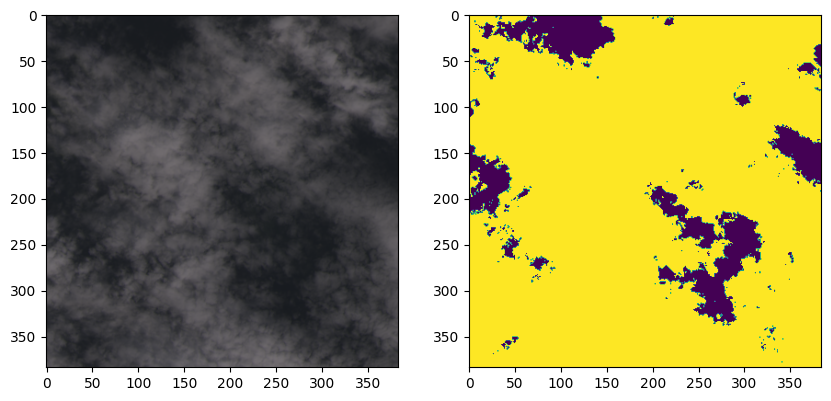

In [32]:
# visualize raw image and ground truth
image_index = 1866

fig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(data.open_as_array(image_index))
ax[1].imshow(data.open_mask(image_index))

# left -> raw image
# right Ground-Truth Mask (as binary image)

In [33]:
len_dataset = len(data)
train_dataset, valid_dataset = torch.utils.data.random_split(data, (int(len_dataset*0.8), int(len_dataset*0.2)))

In [34]:
len_dataset*0.8, len_dataset*0.2

(6720.0, 1680.0)

In [35]:
# Create dataloads sample from dataset

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [36]:
# test dataload
xb, yb = next(iter(train_loader))
xb.shape, yb.shape

(torch.Size([32, 3, 384, 384]), torch.Size([32, 384, 384]))

In [2]:


import torch
import torch.nn as nn
import math
#from torch.nn import GlobalAvgPool2d

__all__ = ['ResNet', 'resnet18']




def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    """ResNet BasicBlock
    """
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None, previous_dilation=1,
                 norm_layer=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=dilation, dilation=dilation, bias=False)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=previous_dilation, dilation=previous_dilation, bias=False)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    """ResNet Bottleneck
    """
    # pylint: disable=unused-argument
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, dilation=1,
                 downsample=None, previous_dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = norm_layer(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride,
            padding=dilation, dilation=dilation, bias=False)
        self.bn2 = norm_layer(planes)
        self.conv3 = nn.Conv2d(
            planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = norm_layer(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dilation = dilation
        self.stride = stride

    def _sum_each(self, x, y):
        assert(len(x) == len(y))
        z = []
        for i in range(len(x)):
            z.append(x[i]+y[i])
        return z

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    # pylint: disable=unused-variable
    def __init__(self, block, layers, num_classes=1000, dilated=False, multi_grid=False,
                 deep_base=True, norm_layer=nn.BatchNorm2d):
        self.inplanes = 128 if deep_base else 64
        super(ResNet, self).__init__()
        if deep_base:
            self.conv1 = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False),
                norm_layer(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
                norm_layer(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            )
        else:
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer=norm_layer)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)
        if dilated:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=1,
                                           dilation=2, norm_layer=norm_layer)
            if multi_grid:
                self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                               dilation=4, norm_layer=norm_layer,
                                               multi_grid=True)
            else:
                self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                               dilation=4, norm_layer=norm_layer)
        else:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                           norm_layer=norm_layer)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                           norm_layer=norm_layer)
        #self.avgpool = GlobalAvgPool2d()
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, norm_layer):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, norm_layer=None, multi_grid=False):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                norm_layer(planes * block.expansion),
            )

        layers = []
        multi_dilations = [4, 8, 16]
        if multi_grid:
            layers.append(block(self.inplanes, planes, stride, dilation=multi_dilations[0],
                                downsample=downsample, previous_dilation=dilation, norm_layer=norm_layer))
        elif dilation == 1 or dilation == 2:
            layers.append(block(self.inplanes, planes, stride, dilation=1,
                                downsample=downsample, previous_dilation=dilation, norm_layer=norm_layer))
        elif dilation == 4:
            layers.append(block(self.inplanes, planes, stride, dilation=2,
                                downsample=downsample, previous_dilation=dilation, norm_layer=norm_layer))
        else:
            raise RuntimeError("=> unknown dilation size: {}".format(dilation))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            if multi_grid:
                layers.append(block(self.inplanes, planes, dilation=multi_dilations[i],
                                    previous_dilation=dilation, norm_layer=norm_layer))
            else:
                layers.append(block(self.inplanes, planes, dilation=dilation, previous_dilation=dilation,
                                    norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        #x = self.avgpool(x)
        #x = x.view(x.size(0), -1)
        #x = self.fc(x)

        return x

 
    def resnet18(**kwargs):
   
          model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
          return model



In [3]:
model = ResNet.resnet18()  # Instantiate the ResNet-18 model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Check if GPU is available
model.to(device)  # Move the model to the device

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [4]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torchvision.models import resnet18
from torch.nn.functional import interpolate

class SemiBasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None, previous_dilation=1, norm_layer=nn.BatchNorm2d):
        super(SemiBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class UpsampleModule(nn.Module):
    def __init__(self, in_chs, decoder_chs, norm_layer):
        super(UpsampleModule, self).__init__()

        self.down_conv = nn.Conv2d(in_chs, decoder_chs, kernel_size=1, bias=False)
        self.down_bn = norm_layer(decoder_chs)
        downsample = nn.Sequential(
            self.down_conv,
            self.down_bn,
        )
        self.conv_enc = SemiBasicBlock(in_chs, decoder_chs, downsample=downsample, norm_layer=norm_layer)
        self.conv_out = SemiBasicBlock(decoder_chs, decoder_chs, norm_layer=norm_layer)
        self.conv_up = nn.ConvTranspose2d(decoder_chs, decoder_chs, kernel_size=2, stride=2, bias=False)

    def forward(self, enc, prev):
        enc = self.conv_up(prev) + self.conv_enc(enc)
        dec = self.conv_out(enc)
        return dec

class FPNHead(nn.Module):
    def __init__(self, in_channels, out_channels, norm_layer):
        super(FPNHead, self).__init__()
        decoder_chs = out_channels
        layer_chs_list = [512, 256, 128, 64]  # Update the layer channels based on your input size

        self.conv_enc2dec = nn.Conv2d(layer_chs_list[0], decoder_chs, kernel_size=1, bias=False)
        self.bn_enc2dec = norm_layer(out_channels)
        self.relu_enc2dec = nn.ReLU(inplace=True)

        self.up3 = UpsampleModule(layer_chs_list[1], decoder_chs, norm_layer)
        self.up2 = UpsampleModule(layer_chs_list[2], decoder_chs, norm_layer)
        self.up1 = UpsampleModule(layer_chs_list[3], decoder_chs, norm_layer)

        self.conv_up0 = nn.ConvTranspose2d(decoder_chs, decoder_chs, kernel_size=2, stride=2, bias=False)
        self.conv_up1 = nn.ConvTranspose2d(decoder_chs, out_channels, kernel_size=2, stride=2, bias=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, c1, c2, c3, c4):
        c4 = self.relu_enc2dec(self.bn_enc2dec(self.conv_enc2dec(c4)))
        c3 = self.up3(c3, c4)
        c2 = self.up2(c2, c3)
        c1 = self.up1(c1, c2)

        c1 = self.conv_up0(c1)
        c1 = self.conv_up1(c1)
        return c1

class FPN(nn.Module):
    def __init__(self, backbone, num_classes, pretrained=False, norm_layer=nn.BatchNorm2d):
        super(FPN, self).__init__()
        self.backbone = backbone
        self.num_classes = num_classes

        if backbone == 'resnet18':
            self.pretrained = resnet18(pretrained=pretrained)
            self.base_forward = self._resnet_base_forward

        in_chs_dict = {"resnet18": 512}  # Update the input channels based on your backbone
        in_chs = in_chs_dict[backbone]
        self.head = FPNHead(in_chs, num_classes, norm_layer)

        self._initialize_weights()

    def _resnet_base_forward(self, x):
        x = self.pretrained.conv1(x)
        x = self.pretrained.bn1(x)
        x = self.pretrained.relu(x)
        x = self.pretrained.maxpool(x)
        c1 = self.pretrained.layer1(x)
        c2 = self.pretrained.layer2(c1)
        c3 = self.pretrained.layer3(c2)
        c4 = self.pretrained.layer4(c3)
        return c1, c2, c3, c4

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        _, _, h, w = x.size()
        c1, c2, c3, c4 = self.base_forward(x)
        x = self.head(c1, c2, c3, c4)
       # x = torch.sigmoid(x)  # Apply sigmoid activation for binary classification
        x = interpolate(x, size=(h, w), mode='bilinear', align_corners=False)  # Resize output to input size
        return x

# Create an instance of the FPN model
fpn = FPN(backbone='resnet18', num_classes=2, pretrained=False)
print(fpn)


FPN(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

d:\softs\conda\envs\TCC\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\softs\conda\envs\TCC\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [40]:
# testing one pass
xb, yb = next(iter(train_loader))
xb.shape, yb.shape

(torch.Size([32, 3, 384, 384]), torch.Size([32, 384, 384]))

In [41]:
# Create an instance of the FPN model
fpn_model = FPN(backbone='resnet18', num_classes=2, pretrained=False)
print(fpn)


# Move the model to the appropriate device (CPU or GPU)
fpn_model = fpn_model.to(device)

# Print the model architecture
print(fpn_model)


FPN(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [42]:
# testing one pass
xb, yb = next(iter(train_loader))
xb.shape, yb.shape

(torch.Size([32, 3, 384, 384]), torch.Size([32, 384, 384]))

In [43]:
device = torch.device('cuda')  # Define the device as CUDA

fpn_model = fpn_model.to('cpu')  # Move the model to the CPU

xb = xb.to('cuda')  # Transfer the input tensor to the CUDA device
yb = yb.to('cuda')  # Transfer the label tensor to the CUDA device

# Testing one pass
xb, yb = next(iter(train_loader))

xb.shape, yb.shape

fpn_model = fpn_model.to('cpu')  # Move the model to the CPU
pred = fpn_model(xb)

pred.shape


torch.Size([32, 2, 384, 384])

In [44]:
import time
from IPython.display import clear_output

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), 'best_resnet18.pth')

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()


In [45]:
loss_fn = nn.CrossEntropyLoss() # choose loss function
opt = torch.optim.Adam(fpn_model.parameters(), lr=0.01) # choos3e gradient function

# start training
train_loss, valid_loss = train(fpn_model, train_loader, test_loader, loss_fn, opt, acc_metric, epochs=5)

Epoch 4/4
----------
valid Loss: 0.2475 Acc: 0.9041896462440491
----------
Training complete in 14m 6s


In [60]:
train_loss
valid_loss

array([0.33848315, 0.42559928, 0.45385715, 0.35669222, 0.24748704],
      dtype=float32)

In [61]:
#convert these lists to PyTorch tensors before calling the .cpu() method.
train_loss = torch.tensor(train_loss)
valid_loss = torch.tensor(valid_loss)


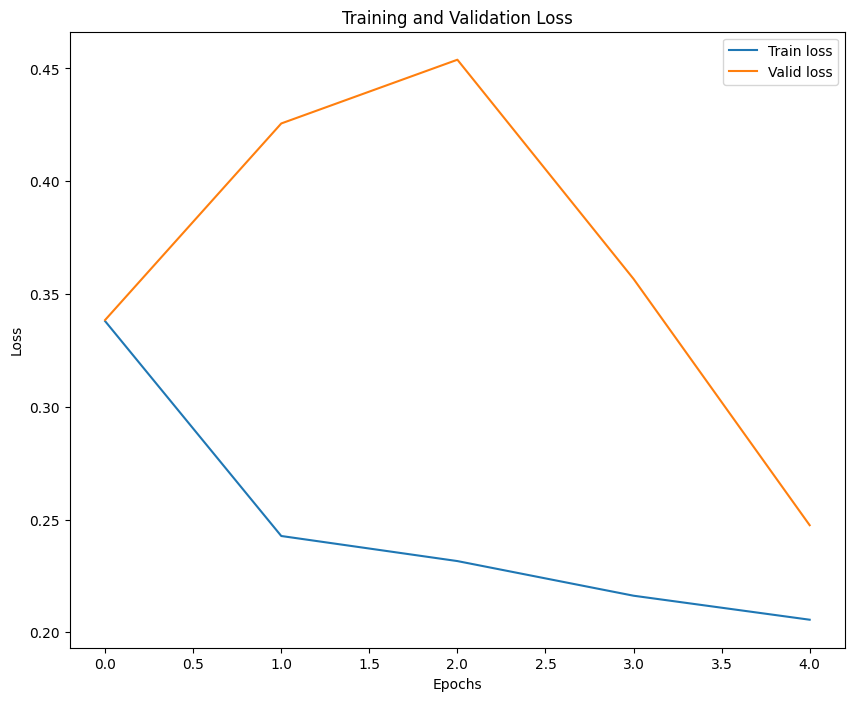

In [62]:
# Move tensors back to CPU for visualization
train_loss = np.array(train_loss.cpu())
valid_loss = np.array(valid_loss.cpu())

plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

In [63]:


def batch_to_(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def batch_to_img(xb, idx):
    channels = xb.shape[1]
    img = np.zeros((xb.shape[2], xb.shape[3], channels))
    for c in range(channels):
        img[..., c] = xb[idx, c]
    return img

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()



In [64]:


xb, yb = next(iter(test_loader))

with torch.no_grad():
    predb = fpn_model(xb.cuda())

predb.shape



torch.Size([32, 2, 384, 384])

torch.Size([32, 3, 384, 384]) torch.Size([32, 384, 384])


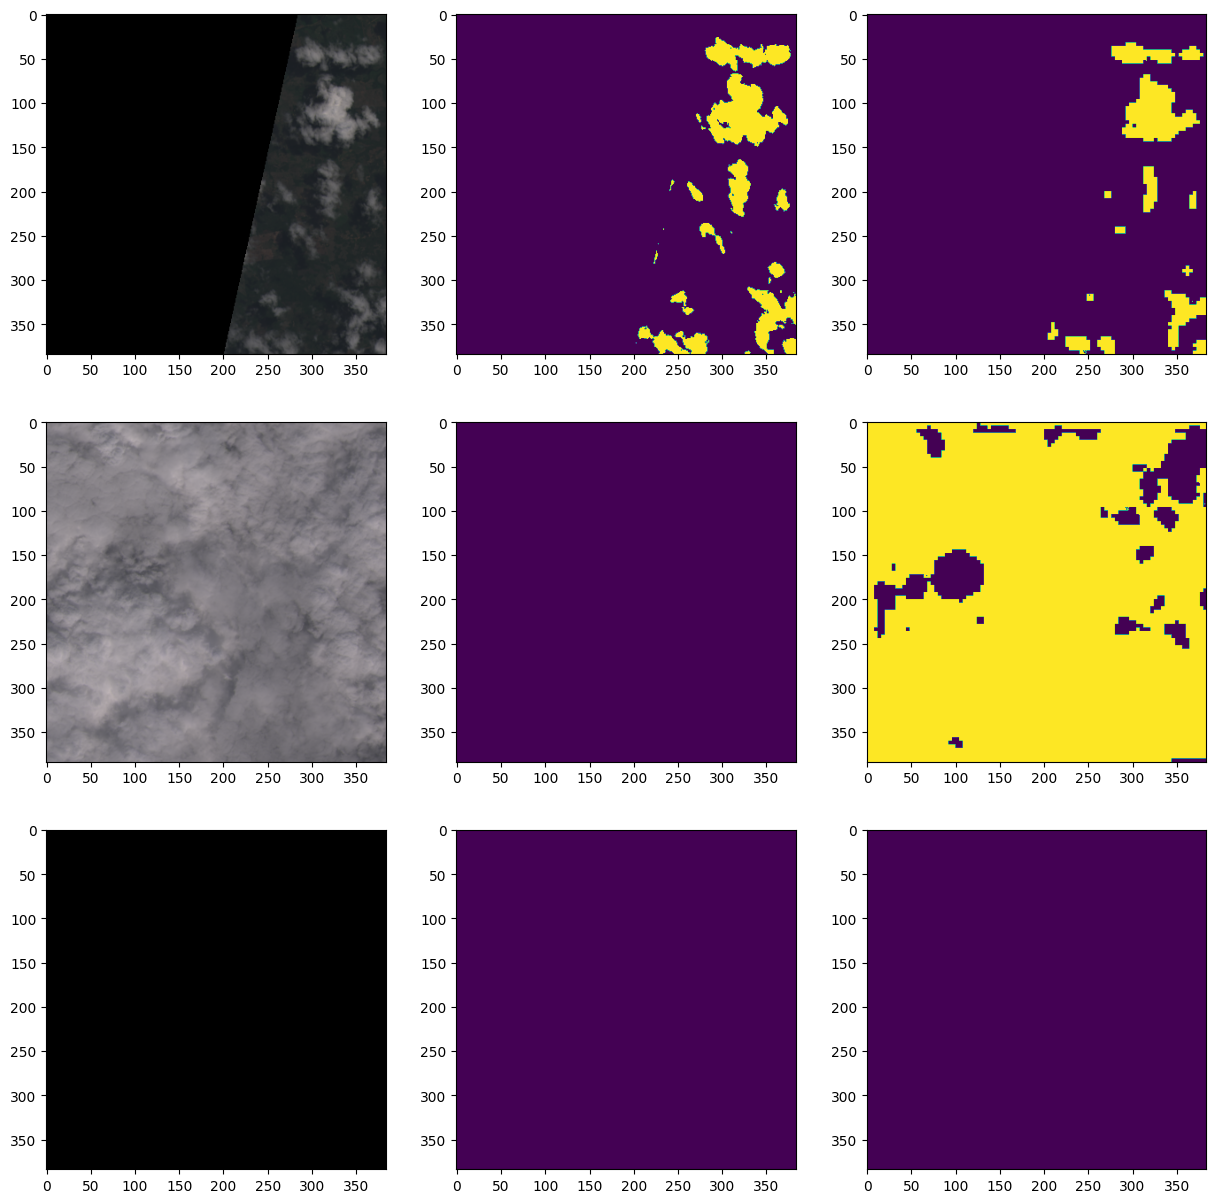

In [77]:
bs = 3
fig, ax = plt.subplots(bs, 3, figsize=(15, bs*5))

# Load a new batch of images and labels
new_xb, new_yb = next(iter(train_loader))  # Replace train_loader with your data loader
print(new_xb.shape, new_yb.shape)
with torch.no_grad():
    new_predb = fpn_model(new_xb.cuda())

for i in range(bs):
    ax[i, 0].imshow(batch_to_img(new_xb, i))
    ax[i, 1].imshow(new_yb[i])
    ax[i, 2].imshow(predb_to_mask(new_predb, i))

plt.show()


In [68]:
pred_flat = pred.view(-1)
yb_flat = yb.view(-1)


In [69]:
pred_binary = (pred_flat > 0.67).float()  # Adjust the threshold as needed


In [70]:
print("Shape of yb_flat:", yb_flat.shape)
print("Size of yb_flat:", yb_flat.size)
print("Shape of pred_binary:", pred_binary.shape)
print("Size of pred_binary:", pred_binary.size)


Shape of yb_flat: torch.Size([4718592])
Size of yb_flat: <built-in method size of Tensor object at 0x000001BDF224E8E0>
Shape of pred_binary: torch.Size([9437184])
Size of pred_binary: <built-in method size of Tensor object at 0x000001BDF22970B0>


In [71]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

# Convert yb to a numpy array
yb_flat = yb.flatten()

# Resize pred_binary_flat to match the shape of yb_flat
pred_binary_flat = pred_binary.flatten()[:yb_flat.shape[0]]

# Compute Intersection over Union (IoU)
iou = jaccard_score(yb_flat, pred_binary_flat)

# Compute accuracy
accuracy = accuracy_score(yb_flat, pred_binary_flat)

# Compute precision
precision = precision_score(yb_flat, pred_binary_flat)

# Compute recall
recall = recall_score(yb_flat, pred_binary_flat)

# Compute F1 score
f1 = f1_score(yb_flat, pred_binary_flat)


In [72]:
print(iou)
print(accuracy)
print(precision)
print(recall)
print(f1)

0.002772847606924948
0.6463500128851997
0.26732730310537534
0.002794081605248056
0.005530360367339885


In [73]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
import numpy as np

# Convert yb to a numpy array
yb_flat = yb.flatten().cpu().numpy()

# Resize pred_binary_flat to match the shape of yb_flat
pred_binary_flat = pred_binary.flatten().cpu().numpy()[:yb_flat.shape[0]]

# Compute confusion matrix
confusion_mat = confusion_matrix(yb_flat, pred_binary_flat)

# Compute Dice coefficient
dice_coefficient = (2 * np.sum(yb_flat * pred_binary_flat)) / (np.sum(yb_flat) + np.sum(pred_binary_flat))

# Compute ROC AUC score
roc_auc = roc_auc_score(yb_flat, pred_binary_flat)

# Generate classification report
classification_rep = classification_report(yb_flat, pred_binary_flat)

print("Confusion Matrix:")
print(confusion_mat)
print("\nDice Coefficient:", dice_coefficient)
print("\nROC AUC Score:", roc_auc)
print("\nClassification Report:")
print(classification_rep)


Confusion Matrix:
[[3045222   12717]
 [1656013    4640]]

Dice Coefficient: 0.005530360367339885

ROC AUC Score: 0.49931769912837876

Classification Report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.78   3057939
           1       0.27      0.00      0.01   1660653

    accuracy                           0.65   4718592
   macro avg       0.46      0.50      0.40   4718592
weighted avg       0.51      0.65      0.51   4718592



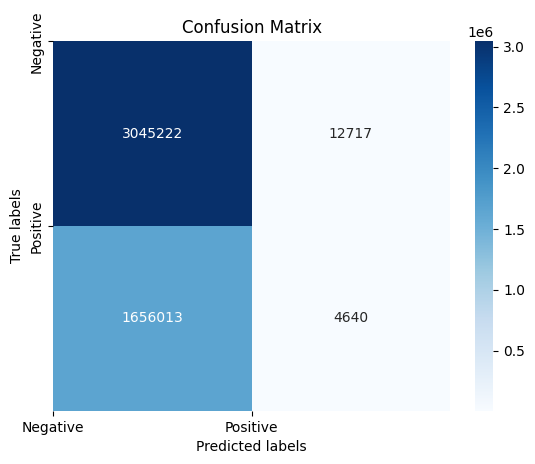

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(yb_flat, pred_binary_flat)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks to the plot
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"])
plt.yticks(ticks=[0, 1], labels=["Negative", "Positive"])

# Display the plot
plt.show()


In [9]:


# def batch_to__predict(xb, idx):
#     img = np.array(xb[idx,0:3])
#     return img.transpose((1,2,0))

# def batch_to_img_predict(xb, idx):
#     channels = xb.shape[1]
#     img = np.zeros((xb.shape[2], xb.shape[3], channels))
#     for c in range(channels):
#         img[..., c] = xb[idx, c]
#     return img

def predb_to_mask_predict(predb):
    p = torch.functional.F.softmax(predb, 0)
    return p.argmax(0).cpu()



./38-Cloud_test/test_red/red_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF
torch.Size([1, 3, 384, 384])
torch.Size([1, 2, 384, 384])


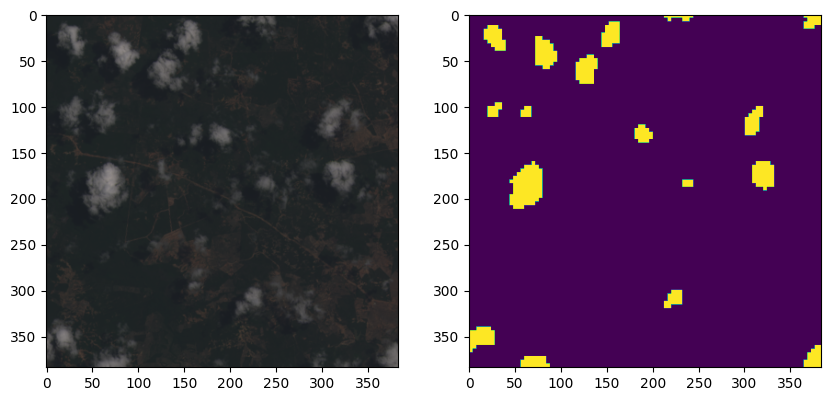

In [82]:
import cv2
# Carregar os dados de entrada usando a classe CloudDataset red_patch_67_4_by_7_LC08_L1TP_034047_20160520_20170324_01_T1
print("./38-Cloud_test/test_red/red_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF")
path = './38-Cloud_training/'
r_dir = f'{path}train_red/red_patch_67_4_by_7_LC08_L1TP_002054_20160520_20170324_01_T1.TIF'
g_dir = f'{path}train_green/green_patch_67_4_by_7_LC08_L1TP_002054_20160520_20170324_01_T1.TIF'
b_dir = f'{path}train_blue/blue_patch_67_4_by_7_LC08_L1TP_002054_20160520_20170324_01_T1.TIF'
# nir_dir = f'{path}train_nir/nir_patch_67_4_by_7_LC08_L1TP_034047_20160520_20170324_01_T1.TIF'

# dataset = CloudDataset(r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True)


red_image = Image.open(r_dir)
green_image = Image.open(g_dir)
blue_image = Image.open(b_dir)



input_tensor = np.stack([red_image, green_image, blue_image], axis=2)

# nir_image = Image.open(nir_dir)

# nir = np.expand_dims(np.array(nir_image), 2)
# input_tensor = np.concatenate([input_tensor, nir], axis=2)


input_tensor = input_tensor.transpose((2, 0, 1))
input_tensor = input_tensor/np.iinfo(input_tensor.dtype).max
input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
input_tensor = input_tensor.unsqueeze(0)

# print(input_tensor.shape)
input_tensor = input_tensor.to(device)
print(input_tensor.shape)

with torch.no_grad():
    output = fpn_model(input_tensor)

print(output.shape)


output = output.squeeze(0)
# output = output.cpu().numpy()


# output = (output * 255).astype(np.uint8)  
# output = Image.fromarray(output[0])  


# output.save('output.png')


input_image = input_tensor[0, 0:3].cpu().numpy().transpose((1, 2, 0))

fig, ax = plt.subplots(1, 2, figsize=(10, 9))
ax[0].imshow(input_image)
ax[1].imshow(predb_to_mask_predict(output))
plt.show()

In [85]:
torch.save(fpn_model.state_dict(), 'best_resnet18_ybb.pth')

In [7]:
# load model
checkpoint_path = './best_resnet18_ybb.pth'  # Replace with the actual path to your checkpoint file
checkpoint = torch.load(checkpoint_path)

model = FPN(backbone='resnet18', num_classes=2, pretrained=False)
# Load the model's state dictionary from the checkpoint
model.load_state_dict(checkpoint)

model.to(device)  # Move the model to the device
model.eval()

d:\softs\conda\envs\TCC\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\softs\conda\envs\TCC\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FPN(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

./38-Cloud_test/test_red/red_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF
torch.Size([1, 3, 384, 384])
torch.Size([1, 2, 384, 384])


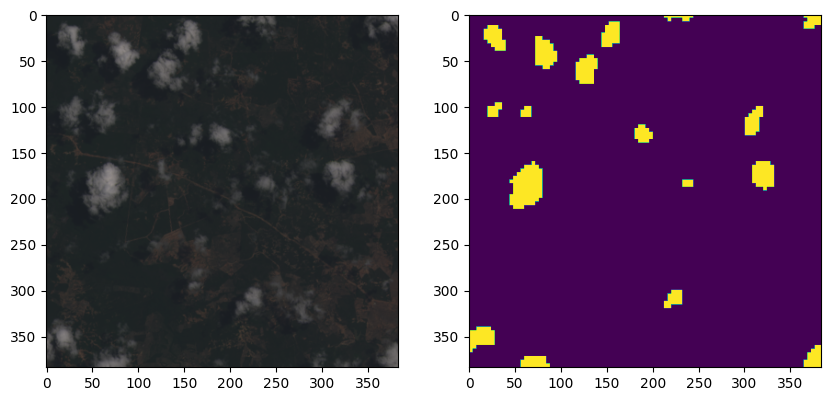

In [87]:
import cv2
# Carregar os dados de entrada usando a classe CloudDataset red_patch_67_4_by_7_LC08_L1TP_034047_20160520_20170324_01_T1
print("./38-Cloud_test/test_red/red_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF")
path = './38-Cloud_training/'
r_dir = f'{path}train_red/red_patch_67_4_by_7_LC08_L1TP_002054_20160520_20170324_01_T1.TIF'
g_dir = f'{path}train_green/green_patch_67_4_by_7_LC08_L1TP_002054_20160520_20170324_01_T1.TIF'
b_dir = f'{path}train_blue/blue_patch_67_4_by_7_LC08_L1TP_002054_20160520_20170324_01_T1.TIF'
# nir_dir = f'{path}train_nir/nir_patch_67_4_by_7_LC08_L1TP_034047_20160520_20170324_01_T1.TIF'

# dataset = CloudDataset(r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True)


red_image = Image.open(r_dir)
green_image = Image.open(g_dir)
blue_image = Image.open(b_dir)



input_tensor = np.stack([red_image, green_image, blue_image], axis=2)

# nir_image = Image.open(nir_dir)

# nir = np.expand_dims(np.array(nir_image), 2)
# input_tensor = np.concatenate([input_tensor, nir], axis=2)


input_tensor = input_tensor.transpose((2, 0, 1))
input_tensor = input_tensor/np.iinfo(input_tensor.dtype).max
input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
input_tensor = input_tensor.unsqueeze(0)

# print(input_tensor.shape)
input_tensor = input_tensor.to(device)
print(input_tensor.shape)

with torch.no_grad():
    output = fpn_model(input_tensor)

print(output.shape)


output = output.squeeze(0)
# output = output.cpu().numpy()


# output = (output * 255).astype(np.uint8)  
# output = Image.fromarray(output[0])  


# output.save('output.png')


input_image = input_tensor[0, 0:3].cpu().numpy().transpose((1, 2, 0))

fig, ax = plt.subplots(1, 2, figsize=(10, 9))
ax[0].imshow(input_image)
ax[1].imshow(predb_to_mask_predict(output))
plt.show()

./38-Cloud_test/test_red/red_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF
torch.Size([1, 3, 384, 384])
torch.Size([1, 2, 384, 384])


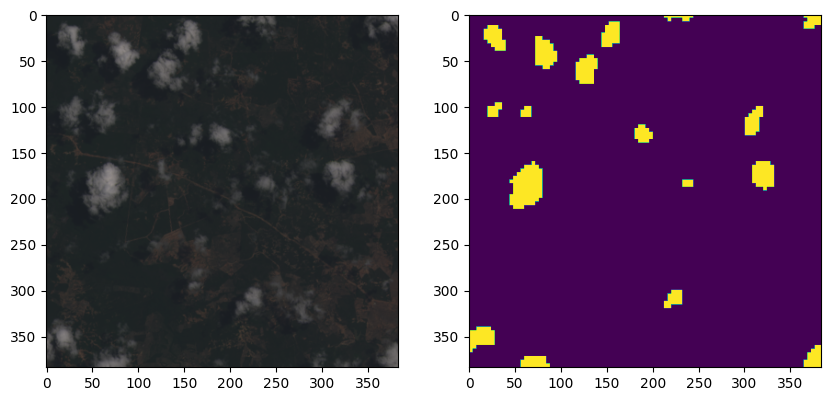

In [10]:
import cv2
# Carregar os dados de entrada usando a classe CloudDataset red_patch_67_4_by_7_LC08_L1TP_034047_20160520_20170324_01_T1
print("./38-Cloud_test/test_red/red_patch_175_9_by_7_LC08_L1TP_050024_20160520_20170324_01_T1.TIF")
path = './38-Cloud_training/'
r_dir = f'{path}train_red/red_patch_67_4_by_7_LC08_L1TP_002054_20160520_20170324_01_T1.TIF'
g_dir = f'{path}train_green/green_patch_67_4_by_7_LC08_L1TP_002054_20160520_20170324_01_T1.TIF'
b_dir = f'{path}train_blue/blue_patch_67_4_by_7_LC08_L1TP_002054_20160520_20170324_01_T1.TIF'
# nir_dir = f'{path}train_nir/nir_patch_67_4_by_7_LC08_L1TP_034047_20160520_20170324_01_T1.TIF'

# dataset = CloudDataset(r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True)


red_image = Image.open(r_dir)
green_image = Image.open(g_dir)
blue_image = Image.open(b_dir)



input_tensor = np.stack([red_image, green_image, blue_image], axis=2)

# nir_image = Image.open(nir_dir)

# nir = np.expand_dims(np.array(nir_image), 2)
# input_tensor = np.concatenate([input_tensor, nir], axis=2)


input_tensor = input_tensor.transpose((2, 0, 1))
input_tensor = input_tensor/np.iinfo(input_tensor.dtype).max
input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
input_tensor = input_tensor.unsqueeze(0)

# print(input_tensor.shape)
input_tensor = input_tensor.to(device)
print(input_tensor.shape)

with torch.no_grad():
    output = model(input_tensor)

print(output.shape)


output = output.squeeze(0)
# output = output.cpu().numpy()


# output = (output * 255).astype(np.uint8)  
# output = Image.fromarray(output[0])  


# output.save('output.png')


input_image = input_tensor[0, 0:3].cpu().numpy().transpose((1, 2, 0))

fig, ax = plt.subplots(1, 2, figsize=(10, 9))
ax[0].imshow(input_image)
ax[1].imshow(predb_to_mask_predict(output))
plt.show()